In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

### Data overview (yellow_tripdata_2019-01.parquet)

In [3]:
df = pd.read_parquet(r'../raw/yellow_tripdata_2019-01.parquet', engine='pyarrow')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


In [4]:
df.shape

(7696617, 19)

In [5]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### Normalize date formatting

In [6]:
df['tpep_pickup_datetime'] = pd.to_datetime(
    df['tpep_pickup_datetime'], 
    format='%Y-%m-%d %H:%M:%S'
)

df['tpep_dropoff_datetime'] = pd.to_datetime(
    df['tpep_dropoff_datetime'],
    format='%Y-%m-%d %H:%M:%S'
)

### Calculate necessary measures
- trip_duration = tpep_dropoff_datetime - tpep_pickup_datetime (minutes)
- avg_speed = trip_distance / trip_duration (mph)

In [7]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df['avg_speed'] = df['trip_distance'] / (df['trip_duration'] / 60)
df = df.replace([np.inf, -np.inf], np.nan)

### Checking for Missing values
We can fill in these missing values with:
- passenger_count: 1
- RatecodeID: 1
- store_and_fwd_flag: N
- congestion_surcharge: 0
- airport_fee: 0
- avg_speed: 0

In [8]:
df[df.columns].isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            28672
trip_distance                  0
RatecodeID                 28672
store_and_fwd_flag         28672
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4884887
airport_fee              7696617
trip_duration                  0
avg_speed                   6553
dtype: int64

In [9]:
df.fillna({
    'passenger_count': 1, # Assume 1 passenger
    'RatecodeID': 1, # Standard rate
    'store_and_fwd_flag': 'N', # Assume not stored and forwarded
    'congestion_surcharge': 0,
    'airport_fee': 0,
    'avg_speed': 0
}, inplace=True)
df[df.columns].isna().sum()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6840\2130931102.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
trip_duration            0
avg_speed                0
dtype: int64

### Set QA rules
- qa_dropoff_after_pickup
- qa_timedate
- qa_duration
- qa_distance
- qa_speed
- qa_payment_type
- qa_total_amount
- qa_tip_amount
- qa_non_neg_amount
- qa_locationID
- qa_ratecodeID
- qa_vendorID
- qa_passenger_count

In [10]:
start_date = pd.Timestamp('2019-01-01 00:00:00')
end_date = pd.Timestamp('2019-02-01 00:00:00')
df['qa_dropoff_after_pickup'] = df['trip_duration'] > 0
df['qa_timedate'] = (df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] < end_date)

df['qa_duration'] = (df['trip_duration'] > 0) & (df['trip_duration'] < 300) # 5 hours
df['qa_distance'] = (df['trip_distance'] > 0 | (df['trip_distance'] == 0) & (df['total_amount'] > 0)) # allow 0 distance with fare
df['qa_speed'] = (df['avg_speed'] > 0) & (df['avg_speed'] <= 30) # 30 mph

df['qa_payment_type'] = (df['payment_type'] >= 0) & (df['payment_type'] <= 6)
df['qa_total_amount'] = (df['total_amount'] > 0) & (df['total_amount'] < 300) # 300 dollars
df['qa_tip_amount'] = (df['tip_amount'] >= 0) & (df['tip_amount'] <= df['fare_amount']) # nobody tips 100%
df['qa_non_neg_amount'] = (
    (df['fare_amount'] > 0)
    & (df['tip_amount'] >= 0)
    & (df['extra'] >= 0)
    & (df['mta_tax'] >= 0)
    & (df['improvement_surcharge'] >= 0)
    & (df['tolls_amount'] >= 0) 
    & (df['congestion_surcharge'] >= 0)
    & (df['airport_fee'] >= 0)
)

df['qa_locationID'] = (
    (df['PULocationID'] > 0)
    & (df['PULocationID'] <= 263) # inside NYC
    & (df['DOLocationID'] > 0)
    & (df['DOLocationID'] <= 265)
)
df['qa_ratecodeID'] = (df['RatecodeID'] > 0) & (df['RatecodeID'] <= 6)
df['qa_vendorID'] = df['VendorID'].isin([1, 2, 6, 7]).astype(int)

df['qa_passenger_count'] = (df['passenger_count'] > 0) & (df['passenger_count'] <= 8)

qa_cols = [col for col in df.columns if col.startswith('qa_')]
df['is_valid_trip'] = df[qa_cols].all(axis=1)
df['is_valid_trip'].value_counts()

is_valid_trip
True     7087346
False     609271
Name: count, dtype: int64

### Generate qa_summary CSV file for month 01

In [11]:
n_total = len(df)
qa_summary = {'month': 1}

qa_cols = [col for col in df.columns if col.startswith('qa_')]

for col in qa_cols:
    n_fail = (df[col] == False).sum()
    qa_summary[f'{col}_fail_count'] = n_fail
    qa_summary[f'{col}_fail_percentage'] = round(n_fail / n_total * 100, 2)

n_invalid = (df['is_valid_trip'] == False).sum()
qa_summary['total_invalid_count'] = n_invalid
qa_summary['total_invalid_percentage'] = round(n_invalid / n_total * 100, 2)

qa_summary_df = pd.DataFrame([qa_summary])
qa_summary_df.to_csv('../reports/qa_summary_2019-01.csv', index=False)
qa_summary_df

,month,qa_dropoff_after_pickup_fail_count,qa_dropoff_after_pickup_fail_percentage,qa_timedate_fail_count,qa_timedate_fail_percentage,qa_duration_fail_count,qa_duration_fail_percentage,qa_distance_fail_count,qa_distance_fail_percentage,qa_speed_fail_count,...,qa_locationID_fail_count,qa_locationID_fail_percentage,qa_ratecodeID_fail_count,qa_ratecodeID_fail_percentage,qa_vendorID_fail_count,qa_vendorID_fail_percentage,qa_passenger_count_fail_count,qa_passenger_count_fail_percentage,total_invalid_count,total_invalid_percentage
0,1,6557,0.09,537,0.01,27187,0.35,55089,0.72,248672,...,163705,2.13,252,0.0,76922,1.0,117390,1.53,609271,7.92


<Axes: xlabel='tpep_pickup_datetime', ylabel='total_amount'>

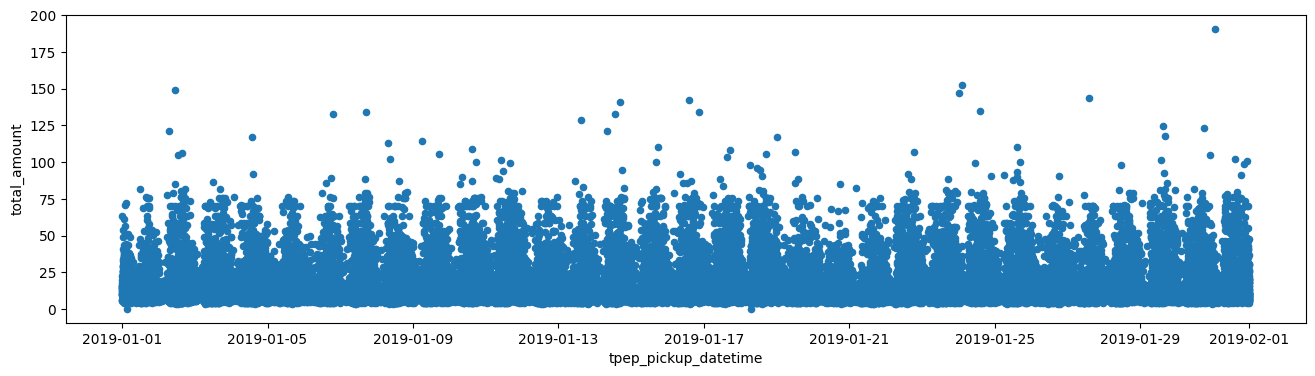

In [12]:
df[df['is_valid_trip']].sample(frac=0.01).plot(
    x='tpep_pickup_datetime', 
    y='total_amount', 
    figsize=(16,4),
    kind='scatter',
)